In [1]:
import face_recognition

reference_image = face_recognition.load_image_file('./input/reference/monica1.jpeg')
reference_face_encoding = face_recognition.face_encodings(reference_image)[0]





In [2]:
import cv2
import os
import json
import numpy as np



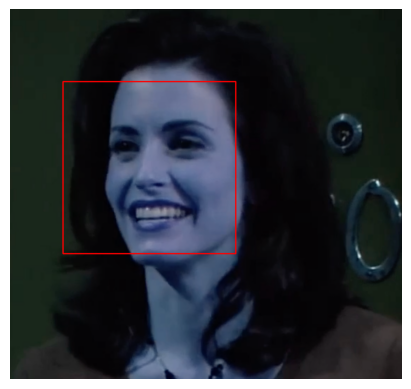

In [3]:
from matplotlib import pyplot as plt

face_locations = face_recognition.face_locations(reference_image)
for top, right, bottom, left in face_locations:
    cv2.rectangle(reference_image, (left, top), (right, bottom), (0, 0, 255), 2)

# Convert the image to RGB (OpenCV uses BGR by default)
rgb_reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(rgb_reference_image)
plt.axis('off')
plt.show()

In [4]:
video_path = './input/video/short.mp4'
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)


In [5]:
video_capture = cv2.VideoCapture(video_path)
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video Info: {frame_width}x{frame_height} at {fps} FPS with {frame_count} frames.")


Video Info: 1920x1080 at 24 FPS with 479 frames.


In [6]:
print(f"Video Info: {frame_width}x{frame_height} at {fps} FPS with {frame_count} frames.")

# Variables
output_metadata = []
face_clip_index = 0
current_clip_frames = []
current_clip_timestamps = []

Video Info: 1920x1080 at 24 FPS with 479 frames.


In [7]:
# frame_number = 0
# while video_capture.isOpened():
#     ret, frame = video_capture.read()
#     if not ret:
#         break

#     # Convert frame to RGB
#     rgb_frame = frame[:, :, ::-1]

#     # Detect faces
#     face_locations = face_recognition.face_locations(rgb_frame)
#     #face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
#     for top, right, bottom, left in face_locations:
#         # Draw a box around the face
#         cv2.rectangle(frame, (left, top), (right, bottom), (0, 0,  
#         255), 2)

#     cv2.imshow('Video', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

In [8]:
# video_capture.release()
# cv2.destroyAllWindows()
# cv2.destroyAllWindows()

In [9]:
# Function to make metadata JSON-serializable
def make_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

In [10]:
# Process video
frame_number = 0
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert frame to RGB
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    rgb_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

    # Debugging: Check frame properties
   # print(f"rgb_frame type: {type(rgb_frame)}, shape: {rgb_frame.shape}, dtype: {rgb_frame.dtype}")


    # Detect faces
    face_locations = face_recognition.face_locations(rgb_frame)
    if not face_locations:
    #    print("No faces found in the frame.")
        continue
    #print(f"Found {len(face_locations)} face(s) in frame {frame_number}.")
    #print(f"face_locations: {face_locations}")

    # Compute face encodings
    try:
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
       # print(f"Face encodings for frame {frame_number}: {face_encodings}")
    except Exception as e:
        print(f"Error computing face encodings: {e}")

    for face_location, face_encoding in zip(face_locations, face_encodings):
        match = face_recognition.compare_faces([reference_face_encoding], face_encoding, tolerance=0.6)
        if match[0]:  # Target face found
            top, right, bottom, left = face_location
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4
            
            current_clip_frames.append(frame)
            current_clip_timestamps.append(frame_number / fps)
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)


    frame_number += 1

    # Save clip if scene change or end of video
    if len(current_clip_frames) > 0 and (not ret or len(current_clip_frames) > fps * 2):  # Adjust clip length as needed
        output_clip_path = os.path.join(output_dir, f"clip_{face_clip_index}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_clip_path, fourcc, fps, (current_clip_frames[0].shape[1], current_clip_frames[0].shape[0]))

        for f in current_clip_frames:
            out.write(f)
        out.release()

        # Metadata
        metadata = {
            "file_name": f"clip_{face_clip_index}.mp4",
            "start_time": current_clip_timestamps[0],
            "end_time": current_clip_timestamps[-1],
            "face_coordinates": [{"frame": i, "coordinates": loc} for i, loc in enumerate(current_clip_frames)]
        }
        output_metadata.append(metadata)
        current_clip_frames = []
        current_clip_timestamps = []
        face_clip_index += 1

# Release resources
video_capture.release()

# Save metadata
with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
    json.dump(output_metadata, f, indent=4, default=make_serializable)

print("Processing complete. Results saved in:", output_dir)


Processing complete. Results saved in: ./output
